# Gerekli Kütüphanelerin Kurulması

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import FastText
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack

# Tüm uyarı mesajlarını bastırmak için
warnings.filterwarnings("ignore")


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [3]:
synthetic_df = pd.read_excel("CleanedSyntheticData.xlsx")
synthetic_df

,Lyrics,Genre
0,"\nIn this game, we warriors, strong and true\n...",Rap
1,"Yo, check it, rollin' with the homies\nCruisin...",Rap
2,"Yo, mic check, let the rhythm flow\nI'm a word...",Rap
3,"\nIn a world of chaos, where madness thrives,\...",Rap
4,"Yo, listen up, let the rhythm take control\nI'...",Rap
...,...,...
995,"\nIn this dusty town, where dreams take flight...",Country
996,"In this honky-tonk town where dreams ignite,\n...",Country
997,"\nThrough the lone star plains, my Ford roams ...",Country
998,The wind howls through these dusty plains\nLik...,Country


In [4]:
kg250_df = pd.read_excel("kaggleset250.xlsx")
kg250_df

,Lyrics,Genre
0,Throw the ball up in the air its tip up They ...,Rap
1,If youre blue and you dont know where to go to...,Rap
2,"Chorus Monsterpiece, Monsterpiece Follow the j...",Rap
3,Verse 1 Scomo Theres a storm in mind Getting w...,Rap
4,"It aint no excuse, its the truth We never had...",Rap
...,...,...
245,The globe of internet advancement is still qui...,Country
246,"I may disappoint, but you can be damn sure Tha...",Country
247,wind blow hard texas plain make people insane ...,Country
248,Like a seedling in the clay When the suns firs...,Country


In [5]:
kg500_df = pd.read_excel("kaggleset500.xlsx")
kg500_df

,Lyrics,Genre
0,"I couldve been a doctor, were it not for a de...",Rap
1,Lights out yep time to go to sleep Time to pu...,Rap
2,"Damn son, whered you find this? My way, four...",Rap
3,"Im a fuckin miracle, I should be in a museum ...",Rap
4,"1970 somethin, 1970 somethin 1970 somethin, 1...",Rap
...,...,...
495,Conway If you loved me half as much as I love ...,Country
496,Went out last night for a little fun Next thin...,Country
497,I hate to write this song I never wanted to B...,Country
498,"Drinkin beer, talkin loud, hangin round with ...",Country


## Doc2Vec

In [8]:
# Metin ön işleme fonksiyonu
def preprocess_text(text):
    text = text.lower() # Metindeki tüm harfleri küçük harfe çevirir
    text = re.sub(r'\d+', '', text) # Tüm rakamları kaldırır
    text = re.sub(r'\W+', ' ', text) # Noktalama işaretlerini kaldırır
    text = text.replace('\n', ' ') 
    words = word_tokenize(text) # Metni kelimelere böler
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words] # Kelimeleri köklerine indirger
    return ' '.join(words)

# Verileri okumak için;
real_data_train = pd.read_excel('kaggleset500.xlsx')
real_data_test = pd.read_excel('kaggleset250.xlsx')
synthetic_data = pd.read_excel('CleanedSyntheticData.xlsx')

# Gerçek ve sentetik verileri ayırmak için;
X_real_train = real_data_train['Lyrics']
y_real_train = real_data_train['Genre']
X_real_test = real_data_test['Lyrics']
y_real_test = real_data_test['Genre']
X_synthetic = synthetic_data['Lyrics']
y_synthetic = synthetic_data['Genre']

# Türleri sayısal değerlere çevirmek için;
label_encoder = LabelEncoder()
y_real_train = label_encoder.fit_transform(y_real_train)
y_real_test = label_encoder.transform(y_real_test)
y_synthetic = label_encoder.transform(y_synthetic)

# Tüm veriler preprocess adımını uygulamak için;
X_real_train = X_real_train.apply(preprocess_text)
X_real_test = X_real_test.apply(preprocess_text)
X_synthetic = X_synthetic.apply(preprocess_text)

# Doc2Vec modeli için;
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(pd.concat([X_real_train, X_synthetic]))]
vector_size = 100
window = 5
min_count = 2
workers = 4
epochs = 40
model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Doc2Vec embeddinglerini elde etmek için;
def extract_doc2vec_embeddings(text):
    return model.infer_vector(text.split())

# Eğitim ve test setlerine embeddingleri uygulamak için;
X_real_train_embeddings = np.array([extract_doc2vec_embeddings(text) for text in X_real_train])
X_real_test_embeddings = np.array([extract_doc2vec_embeddings(text) for text in X_real_test])
X_synthetic_embeddings = np.array([extract_doc2vec_embeddings(text) for text in X_synthetic])

# Eğitim setlerini düzenlemek için;
synthetic_sizes = [100, 200, 500, 1000]
num_genres = 5  # Tür sayısı
train_sets_doc2vec = []

for size in synthetic_sizes: # verilen sentetik boyutuna göre verileri çekebilmek için aralıkları oluşturan kod parçası
    genre_sample_size = size // num_genres
    synthetic_indices = []
    for genre in range(num_genres):
        start_idx = genre * 200
        synthetic_indices.extend(range(start_idx, start_idx + genre_sample_size))
    X_train_embeddings = np.vstack([X_real_train_embeddings, X_synthetic_embeddings[synthetic_indices]])
    y_train = np.concatenate([y_real_train, y_synthetic[synthetic_indices]])
    train_sets_doc2vec.append((X_train_embeddings, y_train))

# Modeller;
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=1000),
    'K-Neighbors': KNeighborsClassifier(),
    'Random Forests': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},

    'SVM': {
        "C": np.arange(1,11), 
        'kernel': ['linear', 'rbf']
    },
    
    'MLP': {
        "alpha": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5],
        "hidden_layer_sizes": [(16,16), (64,64), (128,128,128), (256,256,256,256)],
        "solver": ["adam"], 
        'activation': ['tanh', 'relu']
    },

    'K-Neighbors': {"n_neighbors": np.arange(1,41)},

    'Random Forests': {
        "n_estimators": [100,200,500,1000], 
        "max_features": [2,3], 
        "min_samples_split": [2,5,10,20]
    },
    
    'Gradient Boosting': {
        "learning_rate" : [0.01, 0.1, 0.5],
        "max_depth" : [2,3,5,8],
        "n_estimators" : [50,100,300],
        "subsample" : [1,0.5,0.8],
        "loss" : ['log_loss']
    }
     
}

results = []

# MLP için StandardScaler uygulamak faydalı;
scaler = StandardScaler()

# Eğitim kısmı;
for (X_train, y_train), size in zip(train_sets_doc2vec, synthetic_sizes):
    print(f"\nTraining with {size} synthetic data samples:\n")
    for model_name, model in models.items():
        start_time = time.time()
        
        # MLP için StandartScaler faydalı;
        if model_name == 'MLP':
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_real_test_embeddings)
            grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)
            y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        else:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1) # modeller optimize edilir
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.best_estimator_.predict(X_real_test_embeddings)
        
        best_model = grid_search.best_estimator_ # modele ait en iyi parametreleri almak için
        end_time = time.time()
        total_time = end_time - start_time
        
        # Performans metriklerini hesaplamak için;
        accuracy = accuracy_score(y_real_test, y_pred)
        precision = precision_score(y_real_test, y_pred, average='weighted')
        recall = recall_score(y_real_test, y_pred, average='weighted')
        f1 = f1_score(y_real_test, y_pred, average='weighted')
        
        # Sonuçları kaydetmek için;
        results.append({
            'Model': model_name,
            'Synthetic Size': size,
            'Best Params': grid_search.best_params_,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'CV Time': total_time
        })

        # En iyi parametreleri ekrana yazdırmak için;
        print(f"Best params for {model_name} with {size} synthetic samples: {grid_search.best_params_}, accuracy: {accuracy}")


Training with 100 synthetic data samples:

Best params for Logistic Regression with 100 synthetic samples: {'C': 0.1}, accuracy: 0.448
Best params for SVM with 100 synthetic samples: {'C': 1, 'kernel': 'rbf'}, accuracy: 0.44
Best params for MLP with 100 synthetic samples: {'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (128, 128, 128), 'solver': 'adam'}, accuracy: 0.476
Best params for K-Neighbors with 100 synthetic samples: {'n_neighbors': 18}, accuracy: 0.3
Best params for Random Forests with 100 synthetic samples: {'max_features': 3, 'min_samples_split': 5, 'n_estimators': 500}, accuracy: 0.396
Best params for Gradient Boosting with 100 synthetic samples: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.5}, accuracy: 0.448

Training with 200 synthetic data samples:

Best params for Logistic Regression with 200 synthetic samples: {'C': 0.1}, accuracy: 0.48
Best params for SVM with 200 synthetic samples: {'C': 1, 'kernel': 'rbf

In [ ]:
results_df_doc2vec = pd.DataFrame(results)
models_doc2vec = models.copy()

In [31]:
results_df_doc2vec

,Model,Synthetic Size,Best Params,Accuracy,Precision,Recall,F1 Score,CV Time
0,Logistic Regression,100,{'C': 0.1},0.448,0.415421,0.448,0.424239,3.259734
1,SVM,100,"{'C': 1, 'kernel': 'rbf'}",0.440,0.411371,0.440,0.405994,5.690420
2,MLP,100,"{'activation': 'relu', 'alpha': 0.5, 'hidden_l...",0.476,0.453684,0.476,0.458213,224.907764
3,K-Neighbors,100,{'n_neighbors': 18},0.300,0.370675,0.300,0.211892,0.607139
4,Random Forests,100,"{'max_features': 3, 'min_samples_split': 5, 'n...",0.396,0.357605,0.396,0.358633,46.363482
5,Gradient Boosting,100,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.448,0.426725,0.448,0.434504,1398.720954
6,Logistic Regression,200,{'C': 0.1},0.480,0.441279,0.480,0.447034,0.344068
7,SVM,200,"{'C': 1, 'kernel': 'rbf'}",0.444,0.418118,0.444,0.402346,9.622223
8,MLP,200,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.452,0.432232,0.452,0.440486,213.011076
9,K-Neighbors,200,{'n_neighbors': 27},0.348,0.371655,0.348,0.252570,0.352068


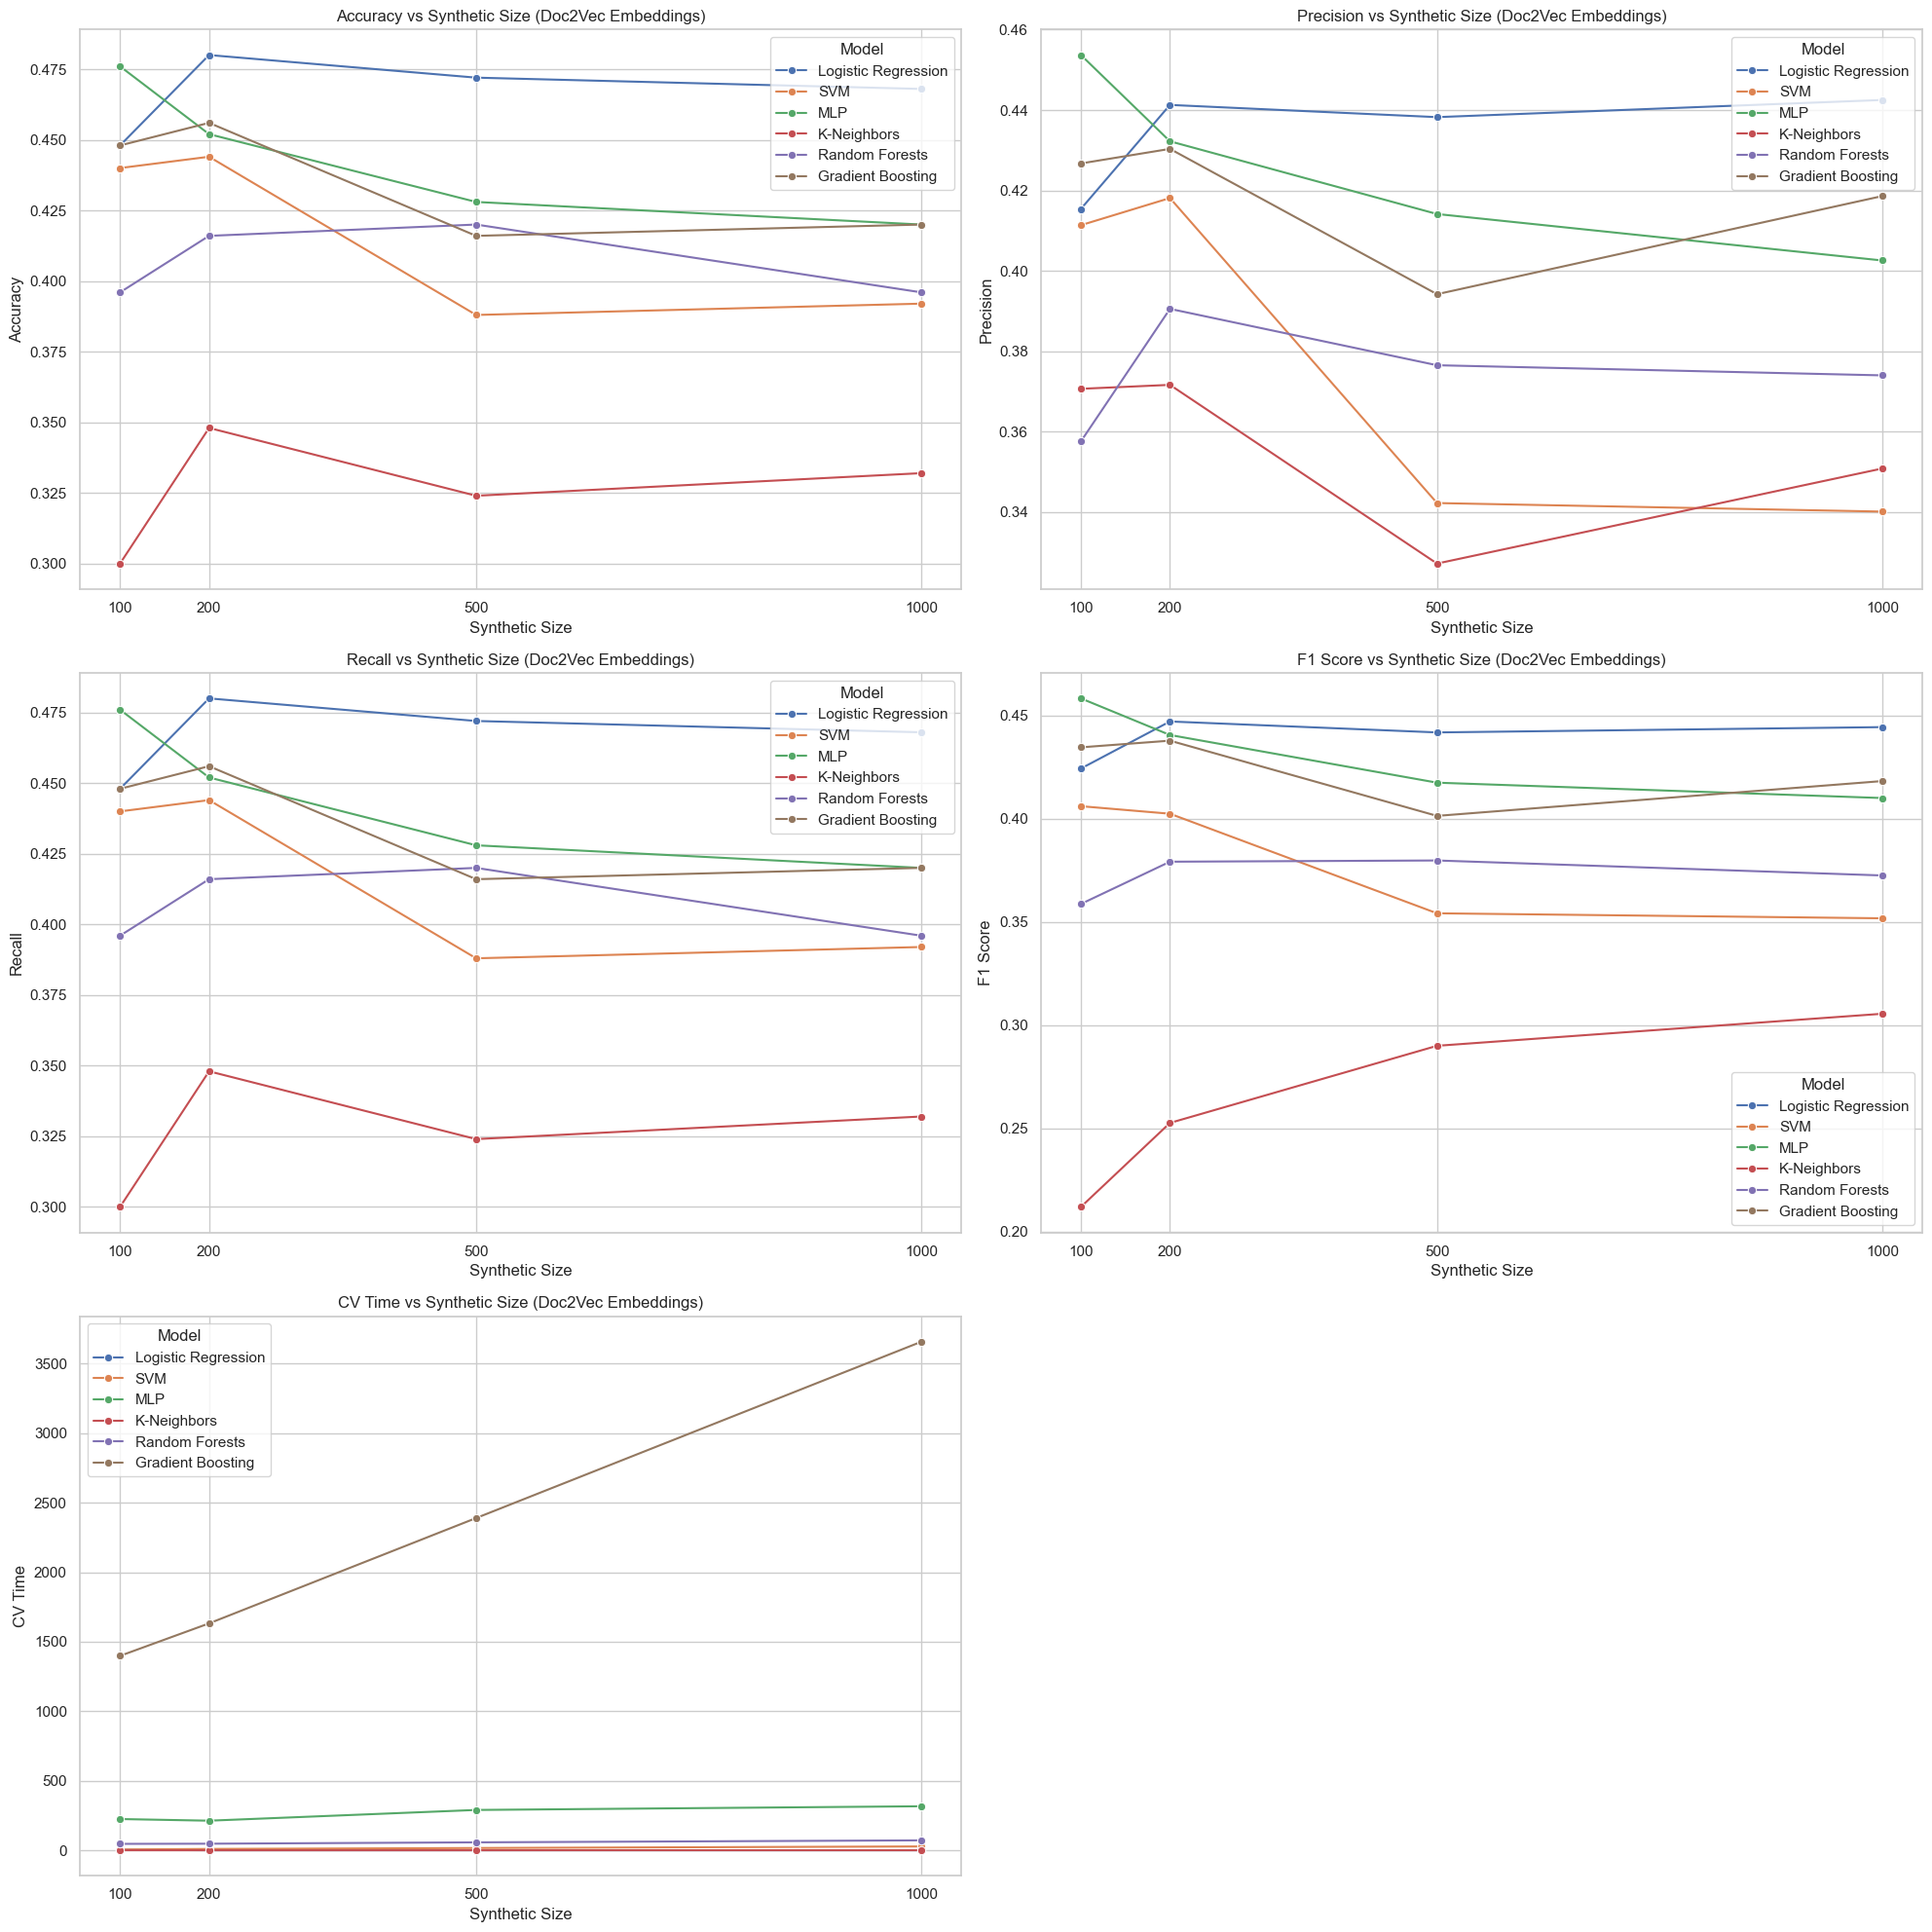

In [45]:
def analysis(results_df, embedding_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 20))

    # Performans metrikleri
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Time']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sns.lineplot(data=results_df, x='Synthetic Size', y=metric, hue='Model', marker='o')
        plt.title(f'{metric} vs Synthetic Size ({embedding_name} Embeddings)')
        plt.xlabel('Synthetic Size')
        plt.ylabel(metric)
        plt.xticks([100, 200, 500, 1000])
        plt.legend(title='Model')

    plt.tight_layout()
    plt.show()

analysis(results_df_doc2vec, "Doc2Vec")

# FastText

In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = text.replace('\n', ' ')
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

real_data_train = pd.read_excel('kaggleset500.xlsx')
real_data_test = pd.read_excel('kaggleset250.xlsx')
synthetic_data = pd.read_excel('CleanedSyntheticData.xlsx')

X_real_train = real_data_train['Lyrics']
y_real_train = real_data_train['Genre']
X_real_test = real_data_test['Lyrics']
y_real_test = real_data_test['Genre']
X_synthetic = synthetic_data['Lyrics']
y_synthetic = synthetic_data['Genre']

label_encoder = LabelEncoder()
y_real_train = label_encoder.fit_transform(y_real_train)
y_real_test = label_encoder.transform(y_real_test)
y_synthetic = label_encoder.transform(y_synthetic)

X_real_train = X_real_train.apply(preprocess_text)
X_real_test = X_real_test.apply(preprocess_text)
X_synthetic = X_synthetic.apply(preprocess_text)

all_texts = pd.concat([X_real_train, X_synthetic])

# fasttext modelini kurmak için;
sentences = [text.split() for text in all_texts]
fasttext_model = FastText(sentences, vector_size=100, min_count=1)

def extract_fasttext_embeddings(text, model, vector_size=100): # fasttext embeddinglerini elde etmek için
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vecs, axis=0)

X_real_train_embeddings = np.array([extract_fasttext_embeddings(text, fasttext_model) for text in X_real_train])
X_real_test_embeddings = np.array([extract_fasttext_embeddings(text, fasttext_model) for text in X_real_test])
X_synthetic_embeddings = np.array([extract_fasttext_embeddings(text, fasttext_model) for text in X_synthetic])

synthetic_sizes = [100, 200, 500, 1000]
num_genres = 5 
train_sets_fasttext = []

for size in synthetic_sizes:
    genre_sample_size = size // num_genres
    synthetic_indices = []
    for genre in range(num_genres):
        start_idx = genre * 200
        synthetic_indices.extend(range(start_idx, start_idx + genre_sample_size))
    X_train_embeddings = np.vstack([X_real_train_embeddings, X_synthetic_embeddings[synthetic_indices]])
    y_train = np.concatenate([y_real_train, y_synthetic[synthetic_indices]])
    train_sets_fasttext.append((X_train_embeddings, y_train))

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=1000),
    'K-Neighbors': KNeighborsClassifier(),
    'Random Forests': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},

    'SVM': {
        "C": np.arange(1,11), 
        'kernel': ['linear', 'rbf']
    },
    
    'MLP': {
        "alpha": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5],
        "hidden_layer_sizes": [(16,16), (64,64), (128,128,128), (256,256,256,256)],
        "solver": ["adam"], 
        'activation': ['tanh', 'relu']
    },

    'K-Neighbors': {"n_neighbors": np.arange(1,41)},

    'Random Forests': {
        "n_estimators": [100,200,500,1000], 
        "max_features": [2,3], 
        "min_samples_split": [2,5,10,20]
    },
    
    'Gradient Boosting': {
        "learning_rate" : [0.01, 0.1, 0.5],
        "max_depth" : [2,3,5,8],
        "n_estimators" : [50,100,300],
        "subsample" : [1,0.5,0.8],
        "loss" : ['log_loss']
    }
     
}

results = []

scaler = StandardScaler()

for (X_train, y_train), size in zip(train_sets_fasttext, synthetic_sizes):
    print(f"\nTraining with {size} synthetic data samples:\n")
    for model_name, model in models.items():
        start_time = time.time()
        
        if model_name == 'MLP':
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_real_test_embeddings)
            grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)
            y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        else:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.best_estimator_.predict(X_real_test_embeddings)
        
        best_model = grid_search.best_estimator_
        end_time = time.time()
        total_time = end_time - start_time
        
        accuracy = accuracy_score(y_real_test, y_pred)
        precision = precision_score(y_real_test, y_pred, average='weighted')
        recall = recall_score(y_real_test, y_pred, average='weighted')
        f1 = f1_score(y_real_test, y_pred, average='weighted')
        
        results.append({
            'Model': model_name,
            'Synthetic Size': size,
            'Best Params': grid_search.best_params_,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'CV Time': total_time
        })

        print(f"Best params for {model_name} with {size} synthetic samples: {grid_search.best_params_}, accuracy: {accuracy}")


Training with 100 synthetic data samples:

Best params for Logistic Regression with 100 synthetic samples: {'C': 10}, accuracy: 0.368
Best params for SVM with 100 synthetic samples: {'C': 10, 'kernel': 'linear'}, accuracy: 0.328
Best params for MLP with 100 synthetic samples: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (16, 16), 'solver': 'adam'}, accuracy: 0.372
Best params for K-Neighbors with 100 synthetic samples: {'n_neighbors': 21}, accuracy: 0.324
Best params for Random Forests with 100 synthetic samples: {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}, accuracy: 0.312
Best params for Gradient Boosting with 100 synthetic samples: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.8}, accuracy: 0.372

Training with 200 synthetic data samples:

Best params for Logistic Regression with 200 synthetic samples: {'C': 10}, accuracy: 0.336
Best params for SVM with 200 synthetic samples: {'C': 10, 'kernel': '

In [ ]:
results_df_fasttext = pd.DataFrame(results)
models_fasttext = models.copy()

In [32]:
results_df_fasttext

,Model,Synthetic Size,Best Params,Accuracy,Precision,Recall,F1 Score,CV Time
0,Logistic Regression,100,{'C': 10},0.368,0.343310,0.368,0.344069,0.301048
1,SVM,100,"{'C': 10, 'kernel': 'linear'}",0.328,0.299764,0.328,0.299276,0.743188
2,MLP,100,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.372,0.364750,0.372,0.367055,256.748871
3,K-Neighbors,100,{'n_neighbors': 21},0.324,0.295499,0.324,0.280582,0.342075
4,Random Forests,100,"{'max_features': 2, 'min_samples_split': 2, 'n...",0.312,0.306139,0.312,0.302323,41.248330
5,Gradient Boosting,100,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.372,0.362843,0.372,0.359373,1405.713256
6,Logistic Regression,200,{'C': 10},0.336,0.312286,0.336,0.307403,0.330074
7,SVM,200,"{'C': 10, 'kernel': 'linear'}",0.336,0.313742,0.336,0.281609,0.942211
8,MLP,200,"{'activation': 'tanh', 'alpha': 0.01, 'hidden_...",0.384,0.379829,0.384,0.379651,219.174469
9,K-Neighbors,200,{'n_neighbors': 21},0.320,0.295029,0.320,0.275975,0.440101


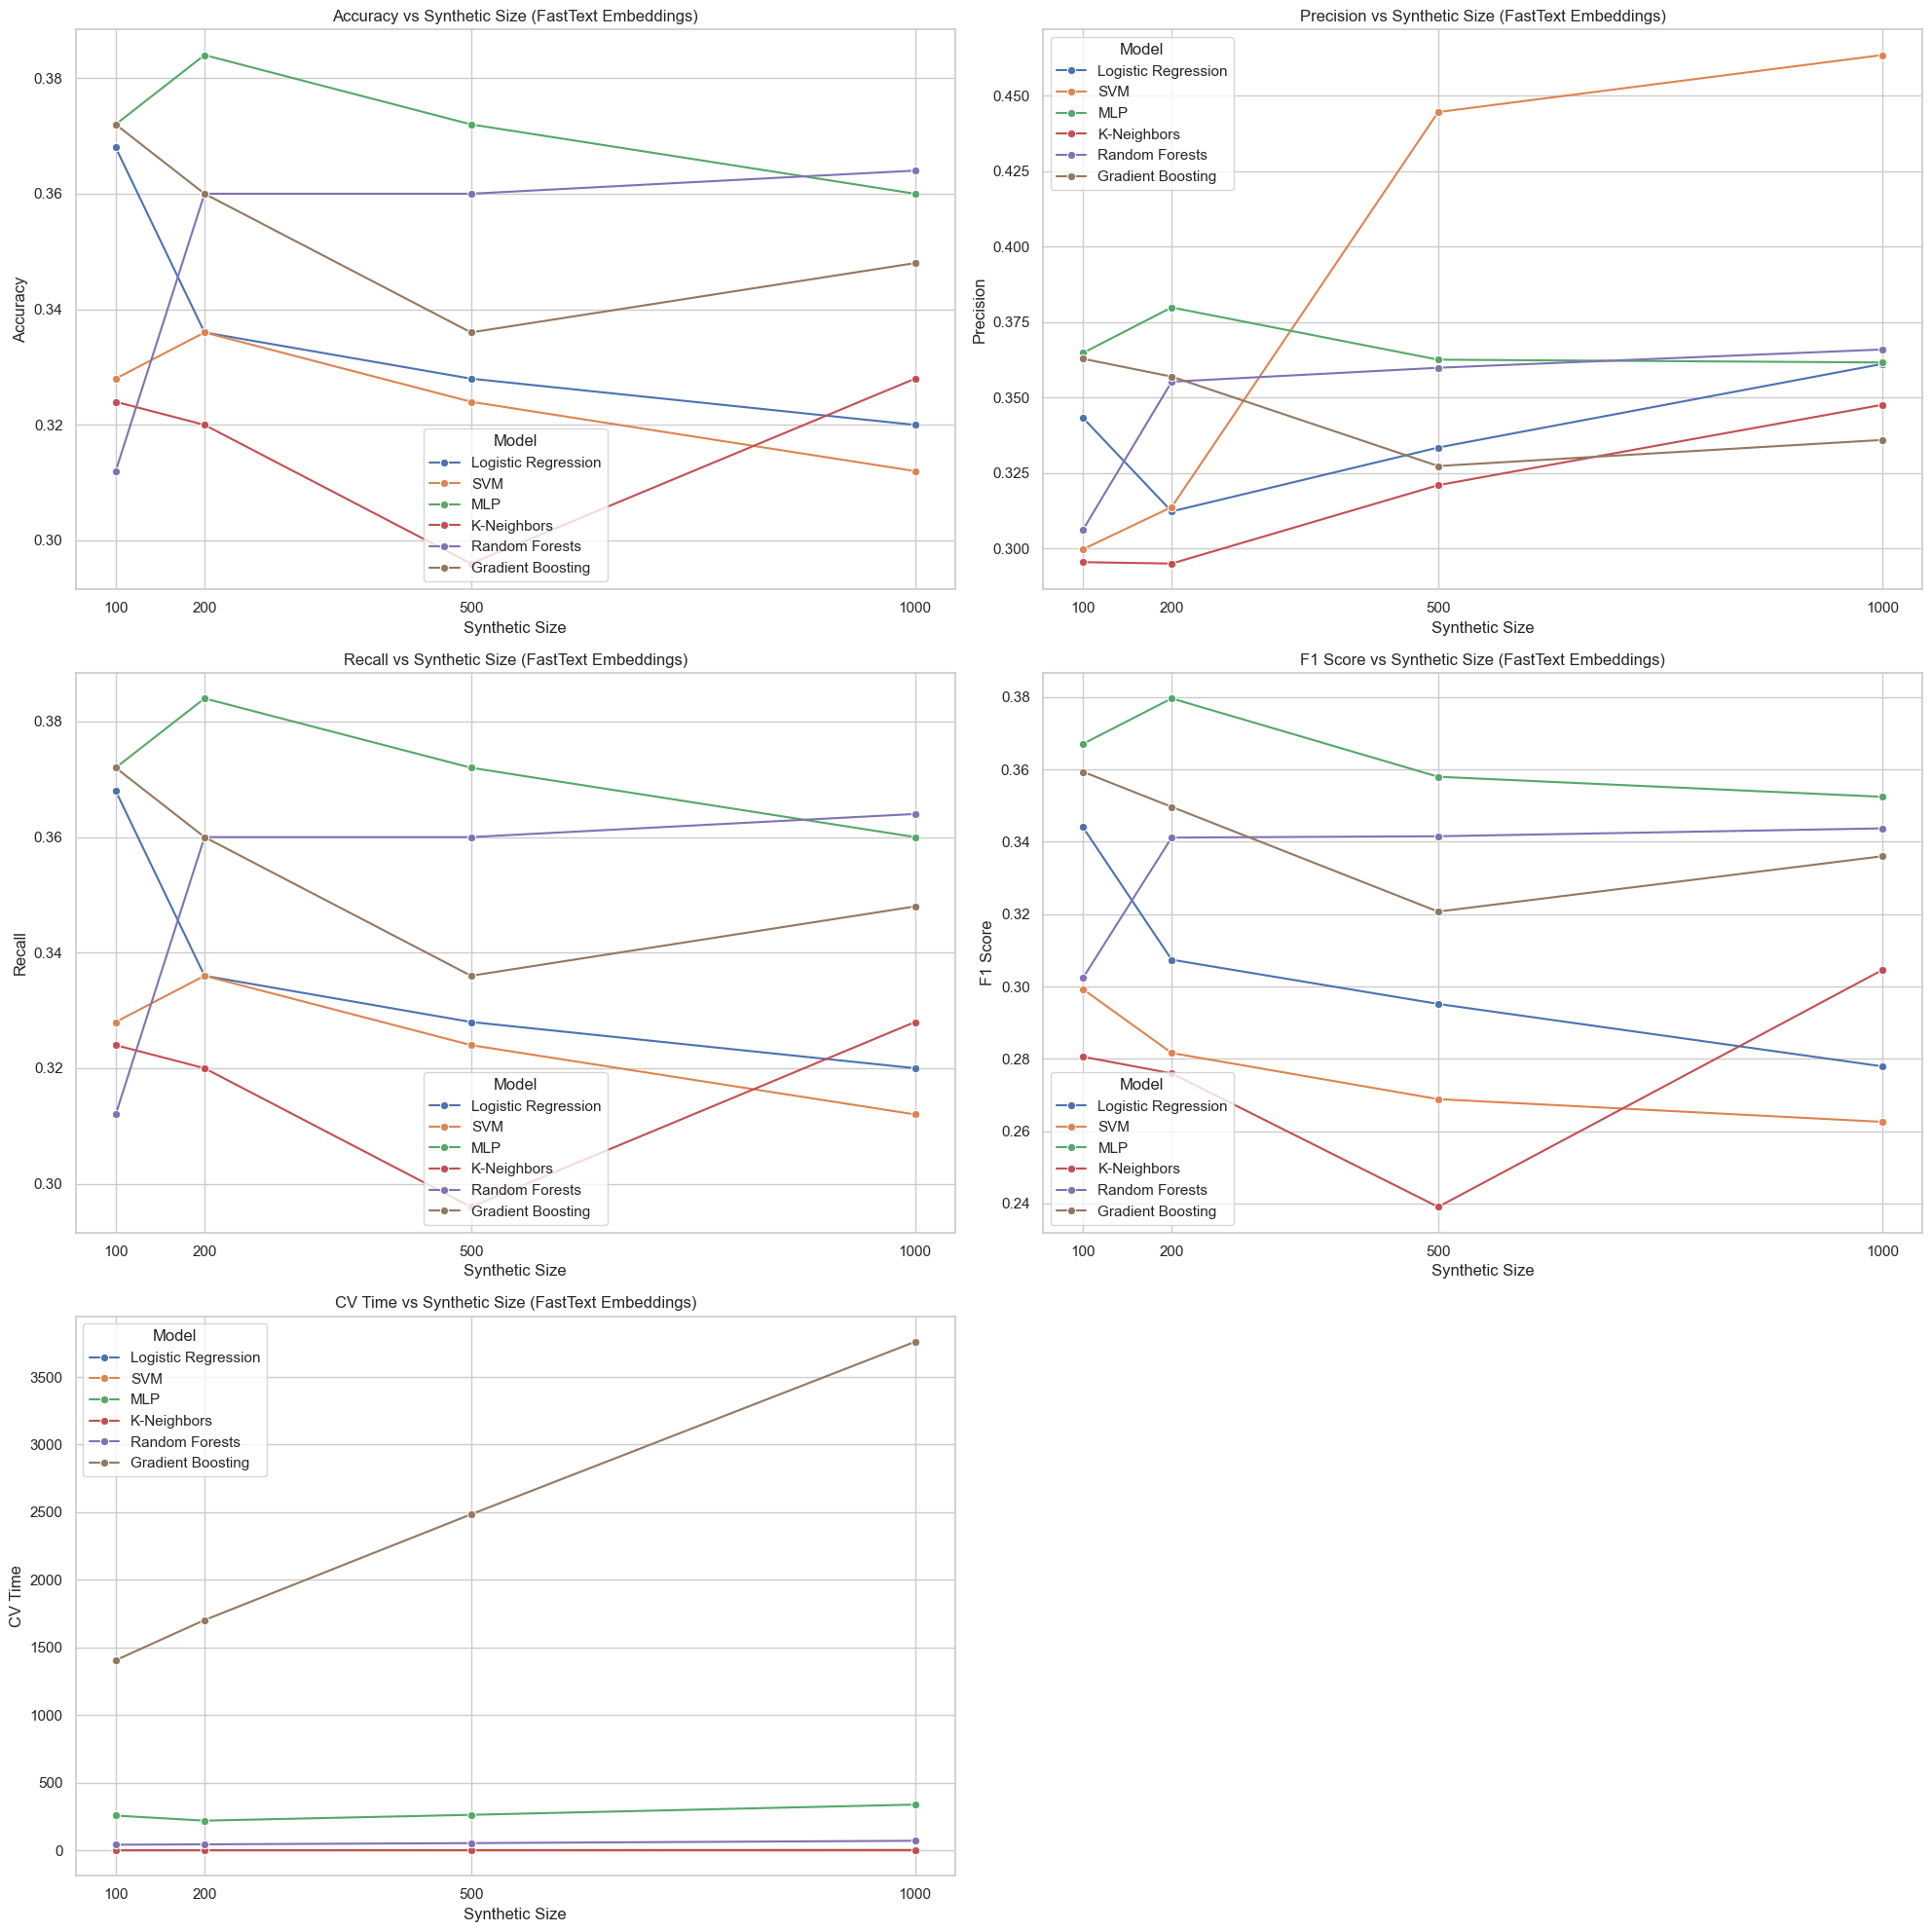

In [46]:
analysis(results_df_fasttext, "FastText")

# TF-IDF

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = text.replace('\n', ' ')
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

real_data_train = pd.read_excel('kaggleset500.xlsx')
real_data_test = pd.read_excel('kaggleset250.xlsx')
synthetic_data = pd.read_excel('CleanedSyntheticData.xlsx')

X_real_train = real_data_train['Lyrics']
y_real_train = real_data_train['Genre']
X_real_test = real_data_test['Lyrics']
y_real_test = real_data_test['Genre']
X_synthetic = synthetic_data['Lyrics']
y_synthetic = synthetic_data['Genre']

label_encoder = LabelEncoder()
y_real_train = label_encoder.fit_transform(y_real_train)
y_real_test = label_encoder.transform(y_real_test)
y_synthetic = label_encoder.transform(y_synthetic)

X_real_train = X_real_train.apply(preprocess_text)
X_real_test = X_real_test.apply(preprocess_text)
X_synthetic = X_synthetic.apply(preprocess_text)

# TF-IDF vektörleri oluşturmak için;
tfidf_vectorizer = TfidfVectorizer()
X_real_train_tfidf = tfidf_vectorizer.fit_transform(X_real_train)
X_real_test_tfidf = tfidf_vectorizer.transform(X_real_test)
X_synthetic_tfidf = tfidf_vectorizer.transform(X_synthetic)

synthetic_sizes = [100, 200, 500, 1000]
num_genres = 5  
train_sets_tfidf = []

for size in synthetic_sizes:
    genre_sample_size = size // num_genres
    synthetic_indices = []
    for genre in range(num_genres):
        start_idx = genre * 200
        synthetic_indices.extend(range(start_idx, start_idx + genre_sample_size))
    X_train_tfidf = vstack([X_real_train_tfidf, X_synthetic_tfidf[synthetic_indices]])
    y_train = np.concatenate([y_real_train, y_synthetic[synthetic_indices]])
    train_sets_tfidf.append((X_train_tfidf, y_train))

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'MLP': MLPClassifier(random_state=42, max_iter=1000),
    'K-Neighbors': KNeighborsClassifier(),
    'Random Forests': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'SVM': {"C": np.arange(1, 11), 'kernel': ['linear', 'rbf']},
    'MLP': {
        "alpha": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5],
        "hidden_layer_sizes": [(16, 16), (64, 64), (128, 128, 128), (256, 256, 256, 256)],
        "solver": ["adam"],
        'activation': ['tanh', 'relu']
    },
    'K-Neighbors': {"n_neighbors": np.arange(1, 41)},
    'Random Forests': {
        "n_estimators": [100, 200, 500, 1000],
        "max_features": [2, 3],
        "min_samples_split": [2, 5, 10, 20]
    },
    'Gradient Boosting': {
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [2, 3, 5, 8],
        "n_estimators": [50, 100, 300],
        "subsample": [1, 0.5, 0.8],
        "loss": ['log_loss']
    }
}

results = []

scaler = StandardScaler()

for (X_train, y_train), size in zip(train_sets_tfidf, synthetic_sizes):
    print(f"\nTraining with {size} synthetic data samples:\n")
    for model_name, model in models.items():
        start_time = time.time()
        
        if model_name == 'MLP':
            X_train_scaled = scaler.fit_transform(X_train.toarray())
            X_test_scaled = scaler.transform(X_real_test_tfidf.toarray())
            grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)
            y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        else:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.best_estimator_.predict(X_real_test_tfidf)
        
        best_model = grid_search.best_estimator_
        end_time = time.time()
        total_time = end_time - start_time
        
        accuracy = accuracy_score(y_real_test, y_pred)
        precision = precision_score(y_real_test, y_pred, average='weighted')
        recall = recall_score(y_real_test, y_pred, average='weighted')
        f1 = f1_score(y_real_test, y_pred, average='weighted')
        
        results.append({
            'Model': model_name,
            'Synthetic Size': size,
            'Best Params': grid_search.best_params_,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'CV Time': total_time
        })

        print(f"Best params for {model_name} with {size} synthetic samples: {grid_search.best_params_}, accuracy: {accuracy}")



Training with 100 synthetic data samples:

Best params for Logistic Regression with 100 synthetic samples: {'C': 1}, accuracy: 0.476
Best params for SVM with 100 synthetic samples: {'C': 2, 'kernel': 'rbf'}, accuracy: 0.476
Best params for MLP with 100 synthetic samples: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (128, 128, 128), 'solver': 'adam'}, accuracy: 0.416
Best params for K-Neighbors with 100 synthetic samples: {'n_neighbors': 3}, accuracy: 0.316
Best params for Random Forests with 100 synthetic samples: {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 500}, accuracy: 0.48
Best params for Gradient Boosting with 100 synthetic samples: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.5}, accuracy: 0.484

Training with 200 synthetic data samples:

Best params for Logistic Regression with 200 synthetic samples: {'C': 1}, accuracy: 0.464
Best params for SVM with 200 synthetic samples: {'C': 1, 'kernel': 'rbf'

In [ ]:
results_df_tf_idf = pd.DataFrame(results)
models_tf_idf = models.copy()

In [24]:
results_df_tf_idf

,Model,Synthetic Size,Best Params,Accuracy,Precision,Recall,F1 Score,CV Time
0,Logistic Regression,100,{'C': 1},0.476,0.459483,0.476,0.463301,4.410167
1,SVM,100,"{'C': 2, 'kernel': 'rbf'}",0.476,0.491017,0.476,0.480617,37.240186
2,MLP,100,"{'activation': 'tanh', 'alpha': 0.1, 'hidden_l...",0.416,0.407729,0.416,0.411381,4731.742000
3,K-Neighbors,100,{'n_neighbors': 3},0.316,0.288610,0.316,0.280298,0.765173
4,Random Forests,100,"{'max_features': 2, 'min_samples_split': 20, '...",0.480,0.474626,0.480,0.464165,51.183553
5,Gradient Boosting,100,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.484,0.522761,0.484,0.497754,2946.539431
6,Logistic Regression,200,{'C': 1},0.464,0.449880,0.464,0.451284,1.794803
7,SVM,200,"{'C': 1, 'kernel': 'rbf'}",0.460,0.470143,0.460,0.460106,44.633065
8,MLP,200,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.412,0.398043,0.412,0.403122,5575.098336
9,K-Neighbors,200,{'n_neighbors': 3},0.320,0.295863,0.320,0.285183,0.765165


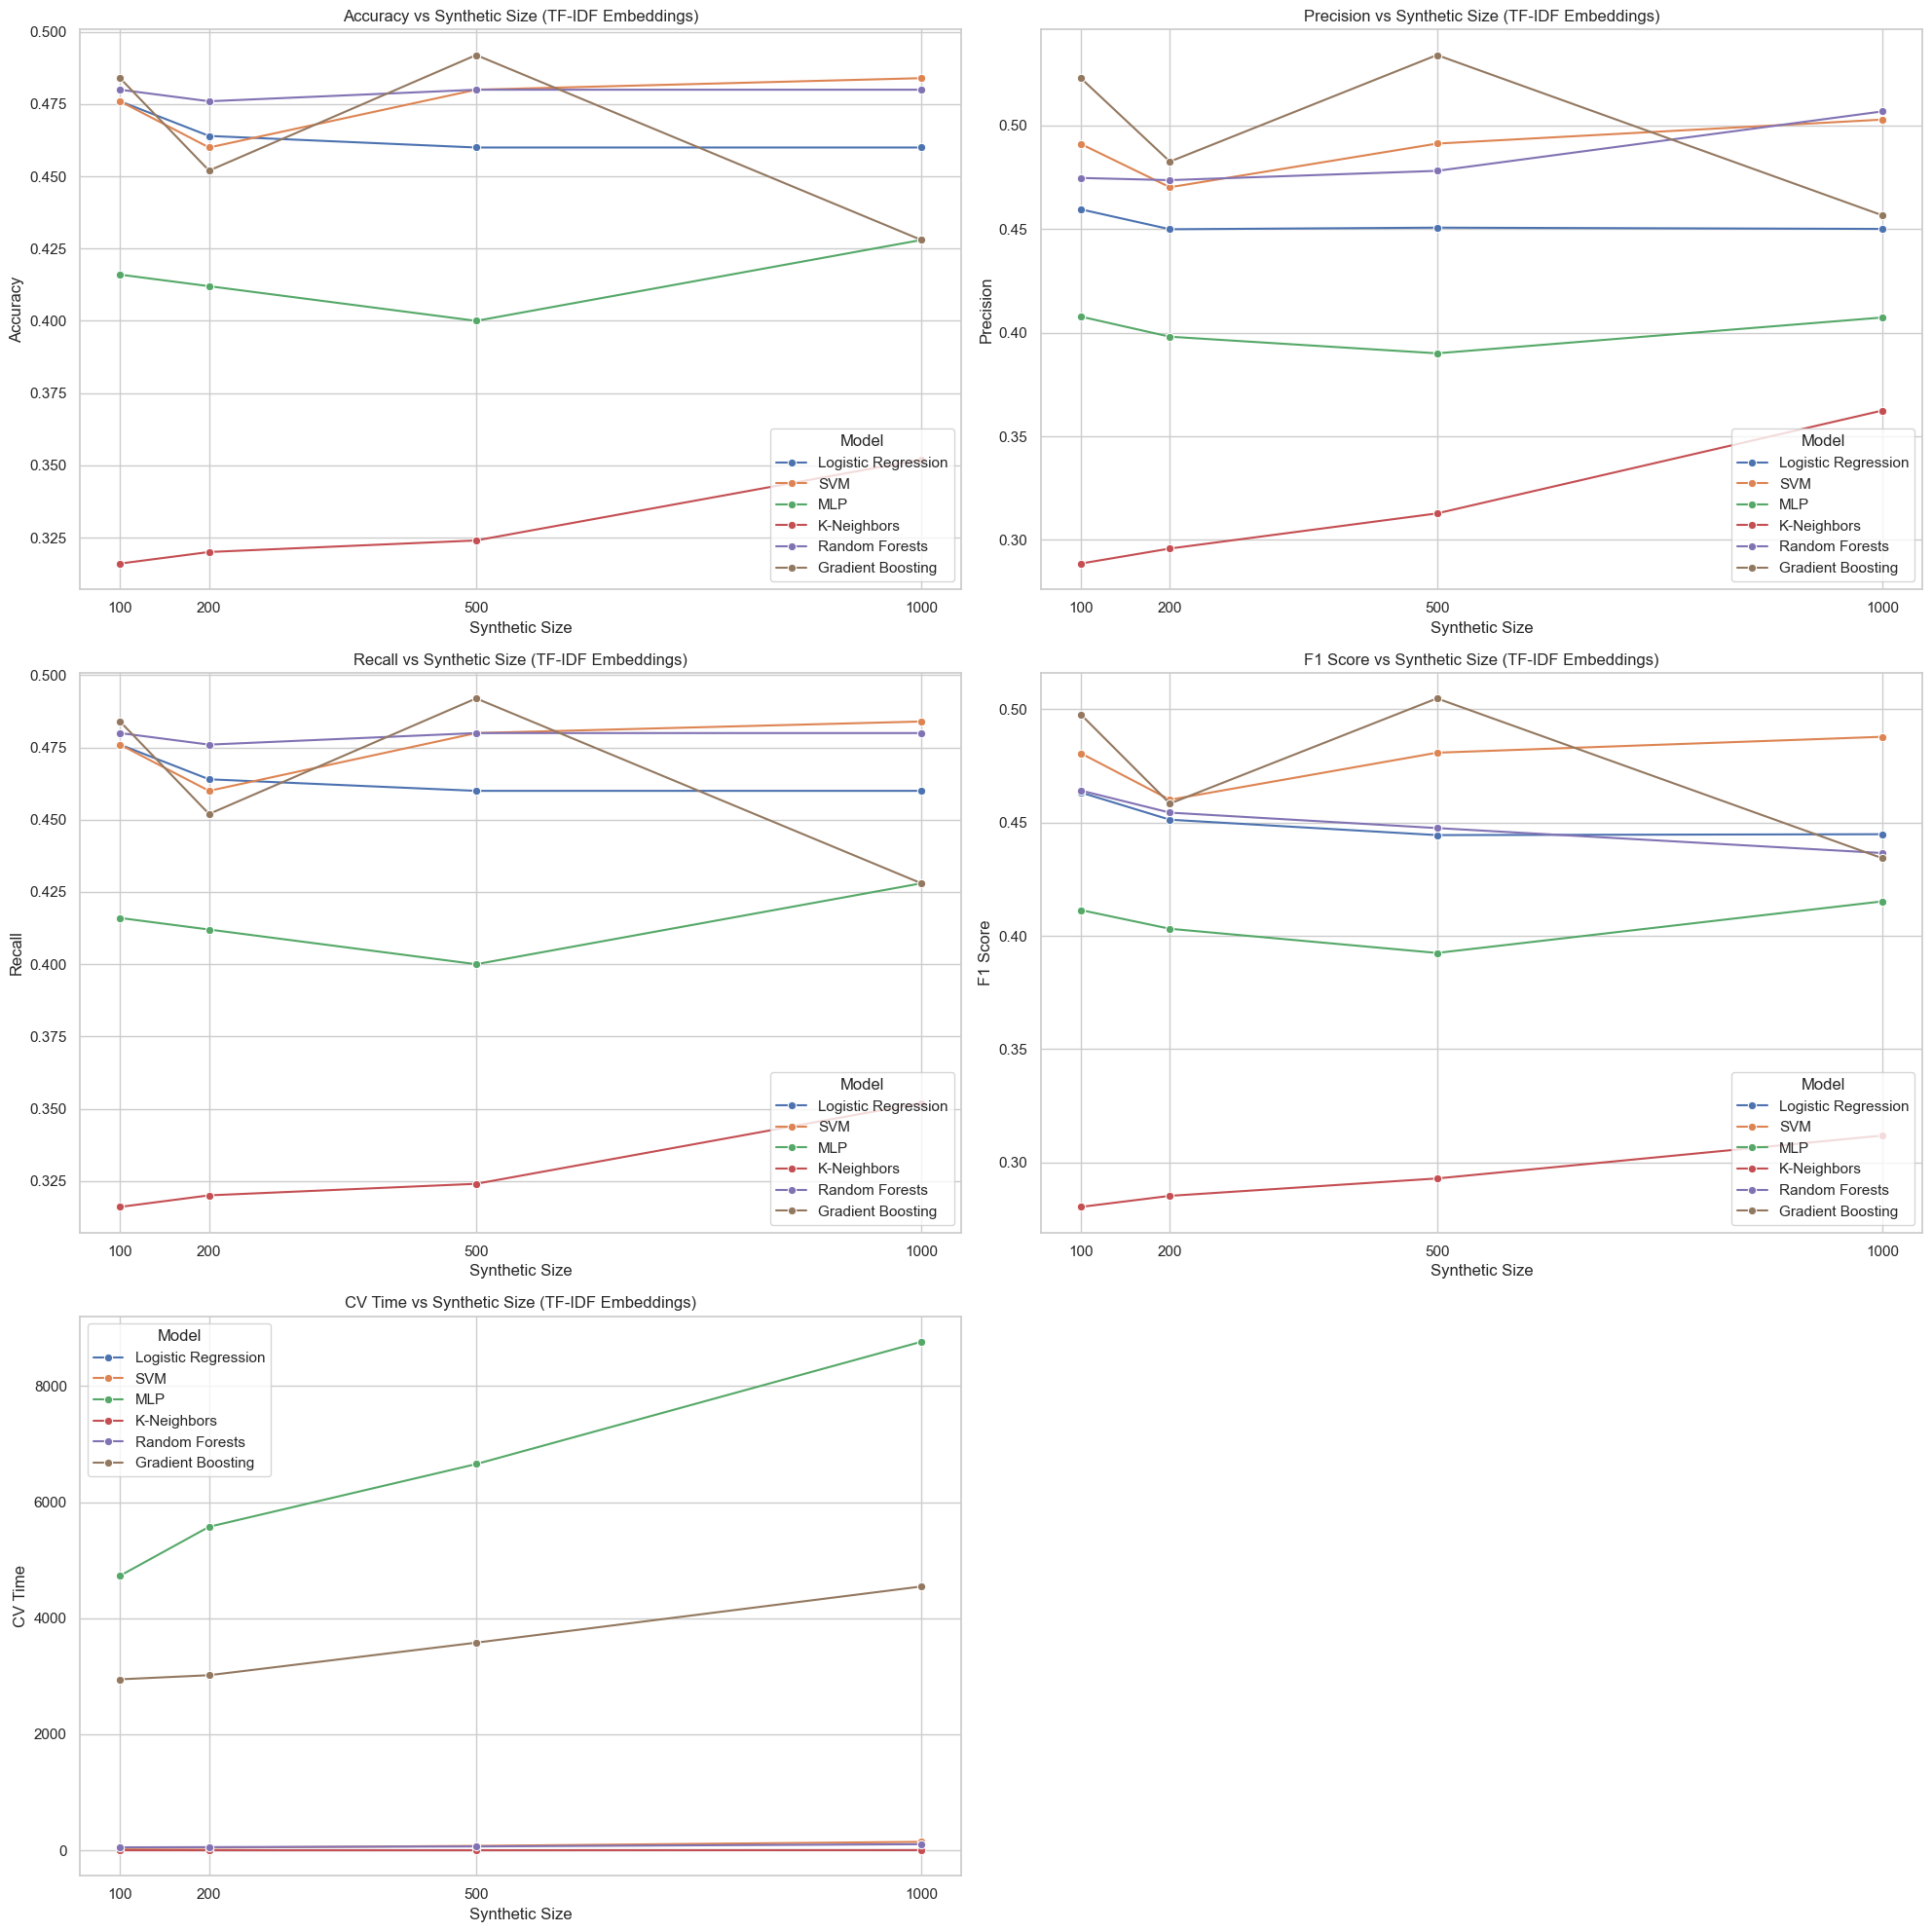

In [48]:
analysis(results_df_tf_idf, "TF-IDF")